In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/airbusgeo/airbus-aircrafts-sample-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/airbusgeo/airbus-aircrafts-sample-dataset


100%|██████████| 87.6M/87.6M [00:06<00:00, 14.2MB/s]


In [3]:
import os
import numpy as np
import pandas as pd
import ast
import torch
import PIL
from tqdm.auto import tqdm
import shutil as sh
from pathlib import Path
import random

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!pip install ultralytics

from IPython import display
display.clear_output()
!yolo checks

Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 30.3/201.2 GB disk)

OS                  Linux-6.1.85+-x86_64-with-glibc2.35
Environment         Colab
Python              3.10.12
Install             pip
RAM                 52.96 GB
CPU                 Intel Xeon 2.20GHz
CUDA                12.1

matplotlib          ✅ 3.7.1>=3.3.0
opencv-python       ✅ 4.8.0.76>=4.6.0
pillow              ✅ 9.4.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.4>=1.4.1
torch               ✅ 2.3.0+cu121>=1.8.0
torchvision         ✅ 0.18.0+cu121>=0.9.0
tqdm                ✅ 4.66.4>=4.64.0
psutil              ✅ 5.9.5
py-cpuinfo          ✅ 9.0.0
pandas              ✅ 2.0.3>=1.1.4
seaborn             ✅ 0.13.1>=0.11.0
ultralytics-thop    ✅ 0.2.8>=0.2.5


In [5]:
!pip install albumentations==1.0.3
display.clear_output()
!pip show albumentations

Name: albumentations
Version: 1.0.3
Summary: Fast image augmentation library and easy to use wrapper around other libraries
Home-page: https://github.com/albumentations-team/albumentations
Author: Buslaev Alexander, Alexander Parinov, Vladimir Iglovikov, Eugene Khvedchenya, Druzhinin Mikhail
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, opencv-python-headless, PyYAML, scikit-image, scipy
Required-by: 


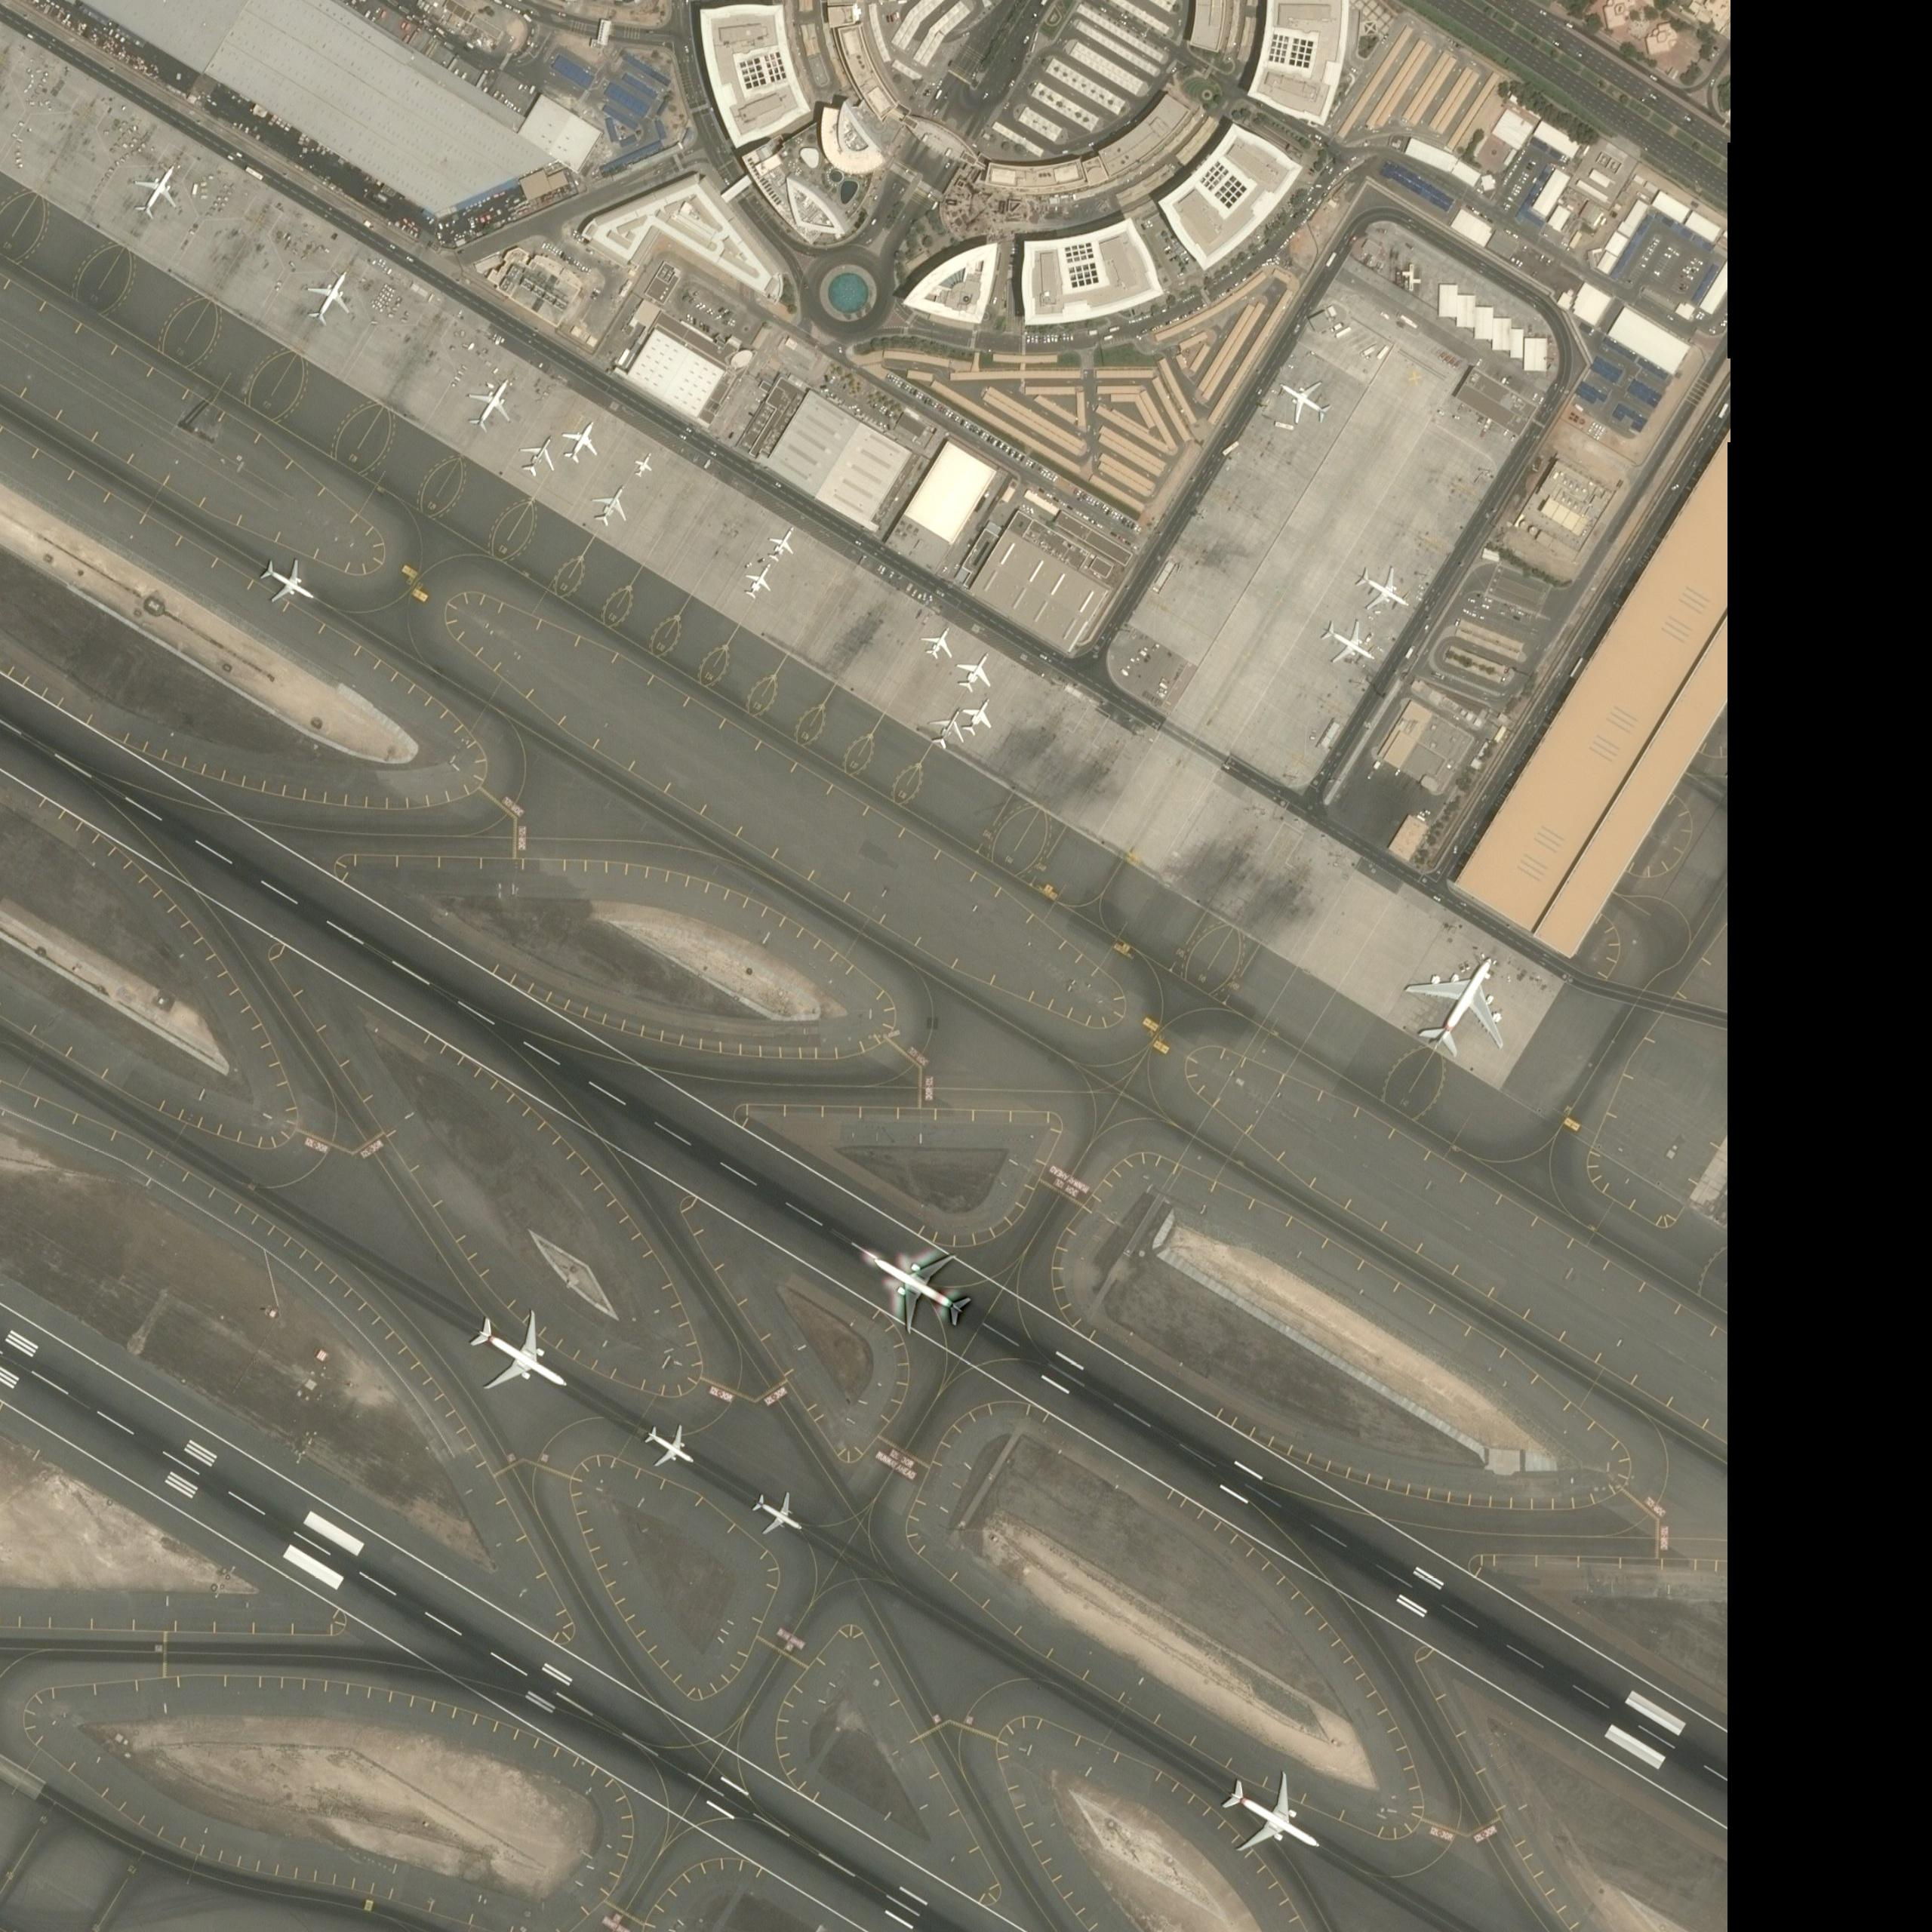

In [6]:
DATA_DIR = Path('/content/airbus-aircrafts-sample-dataset')
img_list = list(DATA_DIR.glob('images/*.jpg'))
pickone = random.choice(img_list)
display.Image(pickone)

In [7]:
print(f"Found {len(img_list)} images files in {DATA_DIR}")

img = PIL.Image.open(pickone)
IMAGE_HEIGHT, IMAGE_WIDTH = img.size
num_channels = len(img.mode)
print("Image size: {}".format((IMAGE_HEIGHT, IMAGE_WIDTH)))
print("Num channels: {}".format(num_channels))

Found 103 images files in /content/airbus-aircrafts-sample-dataset
Image size: (2560, 2560)
Num channels: 3


In [8]:
df = pd.read_csv(DATA_DIR / 'annotations.csv')
# convert a string record into a valid python object
def f(x):
    return ast.literal_eval(x.rstrip('\r\n'))

df = pd.read_csv(DATA_DIR / "annotations.csv",
                converters={'geometry': f})
df.head(10)

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Airplane
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Airplane
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Airplane
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Airplane
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Airplane


In [9]:
def getBounds(geometry):
    try:
        arr = np.array(geometry).T
        xmin = np.min(arr[0])
        ymin = np.min(arr[1])
        xmax = np.max(arr[0])
        ymax = np.max(arr[1])
        return (xmin, ymin, xmax, ymax)
    except:
        return np.nan

def getWidth(bounds):
    try:
        (xmin, ymin, xmax, ymax) = bounds
        return np.abs(xmax - xmin)
    except:
        return np.nan

def getHeight(bounds):
    try:
        (xmin, ymin, xmax, ymax) = bounds
        return np.abs(ymax - ymin)
    except:
        return np.nan


# Create bounds, width and height
df.loc[:,'bounds'] = df.loc[:,'geometry'].apply(getBounds)
df.loc[:,'width'] = df.loc[:,'bounds'].apply(getWidth)
df.loc[:,'height'] = df.loc[:,'bounds'].apply(getHeight)
df.head(10)

,id,image_id,geometry,class,bounds,width,height
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane,"(135, 522, 245, 600)",110,78
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane,"(1025, 284, 1125, 384)",100,100
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane,"(1058, 1503, 1130, 1568)",72,65
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane,"(813, 1518, 885, 1604)",72,86
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane,"(594, 938, 657, 1012)",63,74
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Airplane,"(451, 725, 524, 798)",73,73
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Airplane,"(1543, 1437, 1614, 1497)",71,60
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Airplane,"(1485, 1370, 1561, 1437)",76,67
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Airplane,"(1968, 1624, 2053, 1687)",85,63
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Airplane,"(1659, 1674, 1733, 1746)",74,72


In [10]:
# create a list of images used for validation
fold = 1
num_fold = 5
index = df['image_id'].unique()
val_indexes = index[len(index)*fold//num_fold:len(index)*(fold+1)//num_fold]
print(val_indexes)

['78099b50-f2b6-4319-b462-f33df2966c45.jpg'
 '22291e0b-ebe2-4f3f-b53e-4e709179300a.jpg'
 'cc4f3226-c262-409e-a4b2-a576e776f7f4.jpg'
 '34ae857d-6e71-46b9-b694-d9e40fb093bc.jpg'
 '5c9e817a-dc4b-42ab-952c-3128e2de12e8.jpg'
 'af67041b-f363-47ae-8ddd-f652db3a6bab.jpg'
 '0263270b-e3ee-41dc-aeef-43ff77e66d5b.jpg'
 'd8873734-016a-4b9d-9b9e-8bc47eb13fef.jpg'
 'd0c3d270-f23e-4792-bac0-142a9cc8ccc6.jpg'
 '78400c58-1a7c-4342-a1fb-2117cb7cbc8b.jpg'
 '77f7b57f-5cf2-424d-a952-9847b3c3f35e.jpg'
 'd9399a45-6745-4e59-8903-90640b2ddf9f.jpg'
 '014de911-7810-4f7d-8967-3e5402209f4a.jpg'
 'd3d2b706-9017-41f4-b57e-469038daa634.jpg'
 '4c9d2482-788c-4d68-a3d4-478b2367abce.jpg'
 '576827bc-a94a-4611-8820-f3d56e969151.jpg'
 '4e9164aa-532e-4b76-bce4-060b090da357.jpg'
 '14436c8c-93ec-41af-9fbf-43a5f39f2b98.jpg'
 '7635d63c-6b97-4c9c-a7dc-27773d42ed4c.jpg'
 'ecfe7982-05e5-435f-824b-e24b6846316e.jpg'
 '8df07836-4606-446e-9880-6ed9e0f74543.jpg']


In [11]:
import os
import tqdm.notebook

# Create 512x512 tiles with 64 pix overlap in /content/airbus-aircrafts-sample-dataset/working
TILE_WIDTH = 512
TILE_HEIGHT = 512
TILE_OVERLAP = 64
TRUNCATED_PERCENT = 0.3
_overwriteFiles = True

TILES_DIR = {'train': Path('/content/airbus-aircrafts-sample-dataset/working/train/images/'),
             'val': Path('/content/airbus-aircrafts-sample-dataset/working/val/images/')}
for _, folder in TILES_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)

LABELS_DIR = {'train': Path('/content/airbus-aircrafts-sample-dataset/working/train/labels/'),
              'val': Path('/content/airbus-aircrafts-sample-dataset/working/val/labels/')}
for _, folder in LABELS_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)

# Save one line in .txt file for each tag found inside the tile
def tag_is_inside_tile(bounds, x_start, y_start, width, height, truncated_percent):
    x_min, y_min, x_max, y_max = bounds
    x_min, y_min, x_max, y_max = x_min - x_start, y_min - y_start, x_max - x_start, y_max - y_start

    if (x_min > width) or (x_max < 0.0) or (y_min > height) or (y_max < 0.0):
        return None

    x_max_trunc = min(x_max, width)
    x_min_trunc = max(x_min, 0)
    if (x_max_trunc - x_min_trunc) / (x_max - x_min) < truncated_percent:
        return None

    y_max_trunc = min(y_max, width)
    y_min_trunc = max(y_min, 0)
    if (y_max_trunc - y_min_trunc) / (y_max - y_min) < truncated_percent:
        return None

    x_center = (x_min_trunc + x_max_trunc) / 2.0 / width
    y_center = (y_min_trunc + y_max_trunc) / 2.0 / height
    x_extend = (x_max_trunc - x_min_trunc) / width
    y_extend = (y_max_trunc - y_min_trunc) / height

    return (0, x_center, y_center, x_extend, y_extend)

In [12]:
for img_path in tqdm.notebook.tqdm(img_list):
    # Open image and related data
    pil_img = PIL.Image.open(img_path, mode='r')
    np_img = np.array(pil_img, dtype=np.uint8)

    # Get annotations for image
    img_labels = df[df["image_id"] == img_path.name]
    #print(img_labels)

    # Count number of sections to make
    X_TILES = (IMAGE_WIDTH + TILE_WIDTH + TILE_OVERLAP - 1) // TILE_WIDTH
    Y_TILES = (IMAGE_HEIGHT + TILE_HEIGHT + TILE_OVERLAP - 1) // TILE_HEIGHT

    # Cut each tile
    for x in range(X_TILES):
        for y in range(Y_TILES):

            x_end = min((x + 1) * TILE_WIDTH - TILE_OVERLAP * (x != 0), IMAGE_WIDTH)
            x_start = x_end - TILE_WIDTH
            y_end = min((y + 1) * TILE_HEIGHT - TILE_OVERLAP * (y != 0), IMAGE_HEIGHT)
            y_start = y_end - TILE_HEIGHT
            #print(x_start, y_start)

            folder = 'val' if img_path.name in val_indexes else 'train'
            save_tile_path = TILES_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".jpg")
            save_label_path = LABELS_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".txt")

            # Save if file doesn't exit
            if _overwriteFiles or not os.path.isfile(save_tile_path):
                cut_tile = np.zeros(shape=(TILE_WIDTH, TILE_HEIGHT, 3), dtype=np.uint8)
                cut_tile[0:TILE_HEIGHT, 0:TILE_WIDTH, :] = np_img[y_start:y_end, x_start:x_end, :]
                cut_tile_img = PIL.Image.fromarray(cut_tile)
                cut_tile_img.save(save_tile_path)

            found_tags = [
                tag_is_inside_tile(bounds, x_start, y_start, TILE_WIDTH, TILE_HEIGHT, TRUNCATED_PERCENT)
                for i, bounds in enumerate(img_labels['bounds'])]
            found_tags = [el for el in found_tags if el is not None]

            # save labels
            with open(save_label_path, 'w+') as f:
                for tags in found_tags:
                    f.write(' '.join(str(x) for x in tags) + '\n')

  0%|          | 0/103 [00:00<?, ?it/s]

In [15]:
CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: /content/airbus-aircrafts-sample-dataset/working/train/
val: /content/airbus-aircrafts-sample-dataset/working/val/

# number of classes
nc: 1

# class names
names: ['Aircraft']
"""

with open("data.yaml", "w") as f:
    f.write(CONFIG)

In [18]:
HOME = "/content/airbus-aircrafts-sample-dataset/working/"
!yolo task=detect mode=train model=yolov8s.pt data={HOME}/data.yaml epochs=10 imgsz=512

Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/airbus-aircrafts-sample-dataset/working//data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

In [20]:
!ls /content/runs/detect/train4/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1718384518.0995d02863b0.4575.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


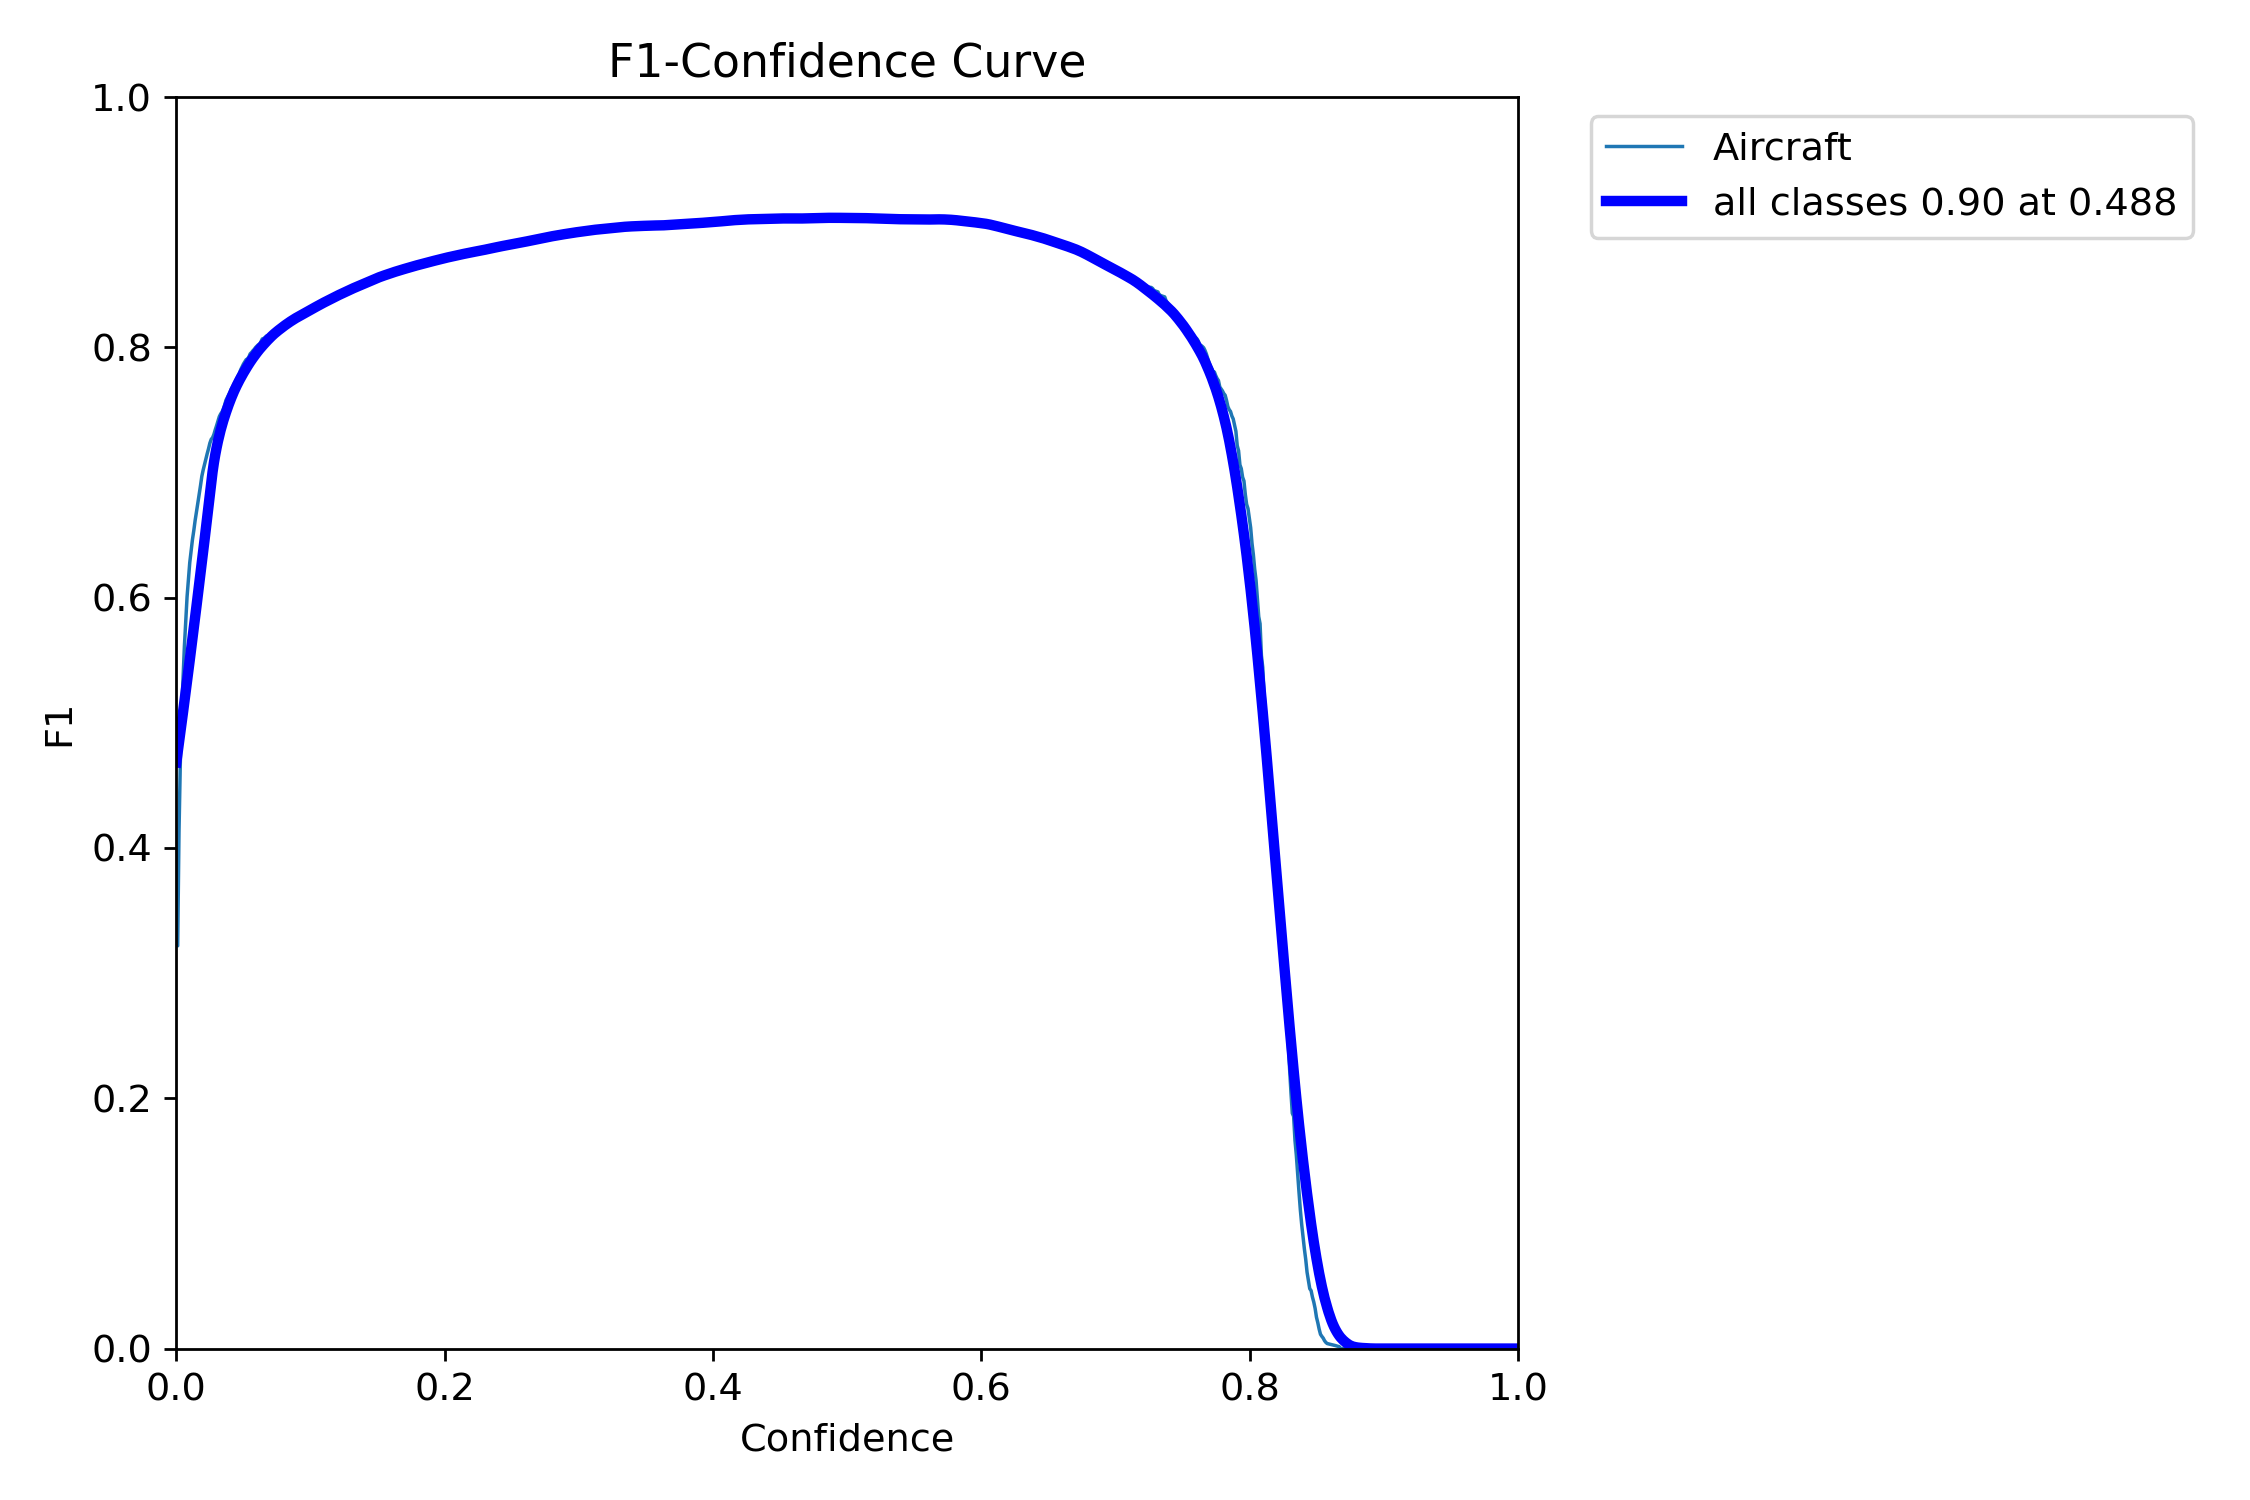

In [22]:
display.Image(filename=f'/content/runs/detect/train4/F1_curve.png', width=600)

In [23]:
import plotly.express as px
import pandas as pd

df = pd.read_csv("/content/runs/detect/train4/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

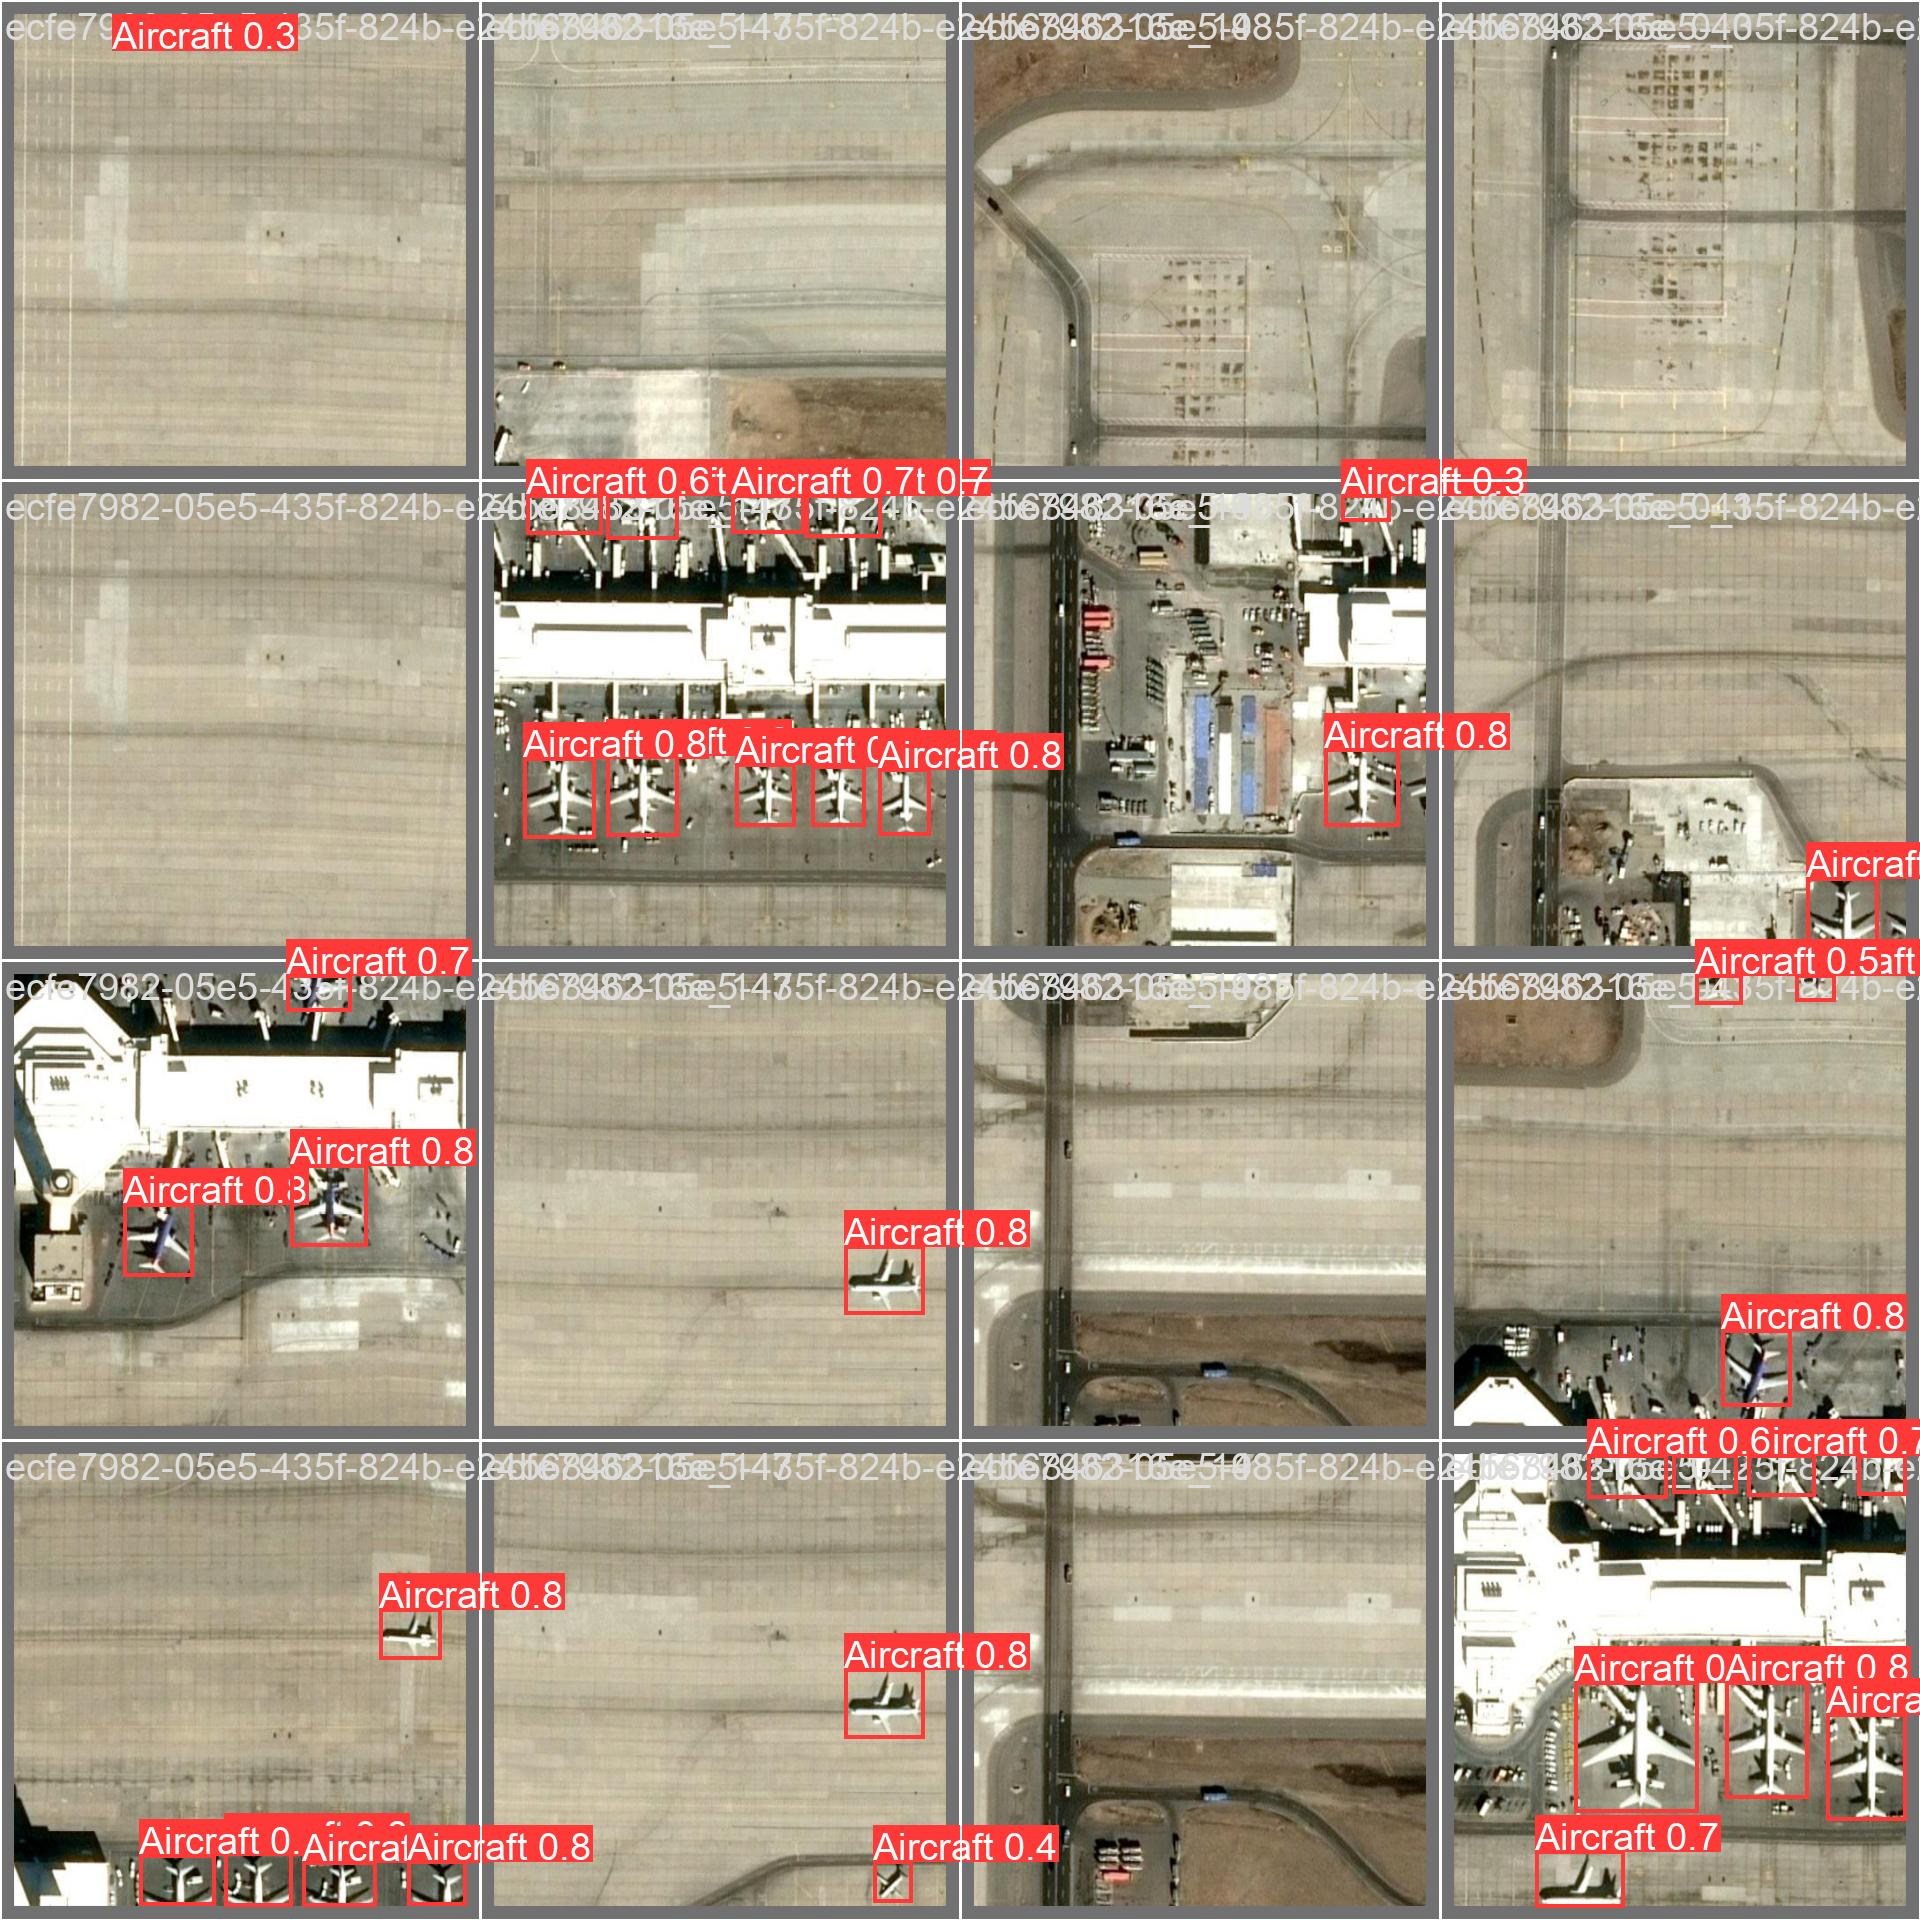

In [24]:
display.Image(filename=f'/content/runs/detect/train4/val_batch0_pred.jpg', width=1000)

In [25]:
!yolo task=detect mode=val model=/content/runs/detect/train4/weights/best.pt data=/content/airbus-aircrafts-sample-dataset/working/data.yaml

Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/airbus-aircrafts-sample-dataset/working/val/labels.cache... 756 images, 273 backgrounds, 0 corrupt: 100% 756/756 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0% 0/48 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 48/48 [00:06<00:00,  6.87it/s]
                   all        756       1459      0.951      0.859      0.902  